In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

not here


In [2]:
# read case
print(os.getcwd())
case = os.getcwd().split(os.sep)[-1]
print(case)

/home/lena/Promotion/neurolib/GUI/current/gui/data/11161
11161


### Bistability

In [3]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

#####################################################
def getclosest(k_, found_solution, exc, inh, already_tried_):
    import numpy as np
    if len(found_solution) == 0:
        print("no solutions found")
        return -1
    
    start_ind = -1
    for j_ in found_solution:
        if j_ not in already_tried_ and j_ != k_:
            start_ind = j_
            break
            
    if start_ind == -1:
        return -1
        
    min_dist = np.sqrt((exc[k_] - exc[start_ind])**2 + (inh[k_] - inh[start_ind])**2)
    min_i = start_ind
        
    print(found_solution, already_tried_)
        
    if len(found_solution) == len(already_tried_):
        print("already tried all options")
        min_i = -1
        return min_i
    
    for i_ in found_solution:
        if i_ not in already_tried_:
            if i_ != k_ and i_ != min_i:
                dist_ = np.sqrt((exc[k_] - exc[i_])**2 + (inh[k_] - inh[i_])**2)
                if dist_ < min_dist:
                    min_dist = dist_
                    min_i = i_
                    
    if min_i == 0 and 0 in already_tried_:
        return -1
    
    return min_i

In [4]:
##### LOAD BOUNDARIES
data_file = 'bi.pickle'
with open(data_file,'rb') as f:
    load_array= pickle.load(f)
exc = load_array[0]
inh = load_array[1]
print(len(exc))
#plt.scatter(exc, inh)

147


In [5]:
bestControl_init = [None] * len(exc)
bestState_init = [None] * len(exc)
cost_init = [None] * len(exc)
runtime_init = [None] * len(exc)
grad_init = [None] * len(exc)
phi_init = [None] * len(exc)
costnode_init = [None] * len(exc)
weights_init = [None] * len(exc)

conv_init = [[False]*2] * len(exc)

In [6]:
bestControl_0 = [None] * len(exc)
bestState_0 = [None] * len(exc)
cost_0 = [None] * len(exc)
runtime_0 = [None] * len(exc)
grad_0 = [None] * len(exc)
phi_0 = [None] * len(exc)
costnode_0 = [None] * len(exc)
weights_0 = [None] * len(exc)

conv_0 = [[False]*2] * len(exc)

In [7]:
bestControl_1 = [None] * len(exc)
bestState_1 = [None] * len(exc)
cost_1 = [None] * len(exc)
runtime_1 = [None] * len(exc)
grad_1 = [None] * len(exc)
phi_1 = [None] * len(exc)
costnode_1 = [None] * len(exc)
weights_1 = [None] * len(exc)

conv_1 = [[False]*2] * len(exc)

In [8]:
initVars = [None] * len(exc)
target = [None] * len(exc)
cost_uncontrolled = [None] * len(exc)

cgv_list = [None, "HS", "FR", "PR", "CD", "LS", "DY", "WYL", "HZ", None]

In [9]:
dur_pre = 10
dur_post = 10

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-32
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

c_var = [ [0], [1], [0,1]]
p_var = [ [0], [0], [0]]

### CURRENTS
cntrl_vars_0 = [0,1]
prec_vars = [0]

if case[0] == '0':    # low to high
    max_I = [3., -3.]
elif case[0] == '1':
    max_I = [-3., 3.]
    
if case[1] == '0':    # sparsity
    factor_ws = 1.
    factor_we = 0.
elif case[1] == '1':  # energy
    factor_ws = 0.
    factor_we = 1.
    
if case[3] == '0':
    cntrl_vars_init = [0]
elif case[3] == '1':
    cntrl_vars_init = [1]
elif case[3] == '2':
    cntrl_vars_init = [0,1]
elif case[3] == '3':
    cntrl_vars_init = [0]
    conv_init = [[True]*2] * len(exc)
    case_read = case[0] + case[1] + case[2] + str(int(case[3])-3) + '0'
    read_file = os.path.join( os.getcwd()[:-5], case_read, 'control_init_' + case_read + '.pickle')
elif case[3] == '4':
    cntrl_vars_init = [1]
    conv_init = [[True]*2] * len(exc)
    case_read = case[0] + case[1] + case[2] + str(int(case[3])-3) + '0'
    read_file = os.path.join( os.getcwd()[:-5], case_read, 'control_init_' + case_read + '.pickle')
elif case[3] == '5':
    cntrl_vars_init = [0,1]
    conv_init = [[True]*2] * len(exc)
    case_read = case[0] + case[1] + case[2] + str(int(case[3])-3) + '0'
    read_file = os.path.join( os.getcwd()[:-5], case_read, 'control_init_' + case_read + '.pickle')
elif case[3] == '6':
    cntrl_vars_init = [0]
    conv_init = [[True]*2] * len(exc)
    case_read = case[0] + case[1] + case[2] + str(int(case[3])-6) + '0'
    read_file = os.path.join( os.getcwd()[:-5], case_read, 'control_init_' + case_read + '.pickle')
elif case[3] == '7':
    cntrl_vars_init = [1]
    conv_init = [[True]*2] * len(exc)
    case_read = case[0] + case[1] + case[2] + str(int(case[3])-6) + '0'
    read_file = os.path.join( os.getcwd()[:-5], case_read, 'control_init_' + case_read + '.pickle')
elif case[3] == '8':
    cntrl_vars_init = [0,1]
    conv_init = [[True]*2] * len(exc)
    case_read = case[0] + case[1] + case[2] + str(int(case[3])-6) + '0'
    read_file = os.path.join( os.getcwd()[:-5], case_read, 'control_init_' + case_read + '.pickle')
    
if case[4] == '0':
    dur = 100
    trans_time = 0.8
elif case[4] == '1':
    dur = 400
    trans_time = 0.95
    
maxC = [5., -5., 0.18, 0.]

n_dur = int(np.around(dur/aln.params.dt + 1.,1))
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

In [10]:
init_file = 'control_init_' + case + '.pickle'
final_file = 'control_' + case + '.pickle'
case_1 = case[0] + case[1] + '0' + case[3] + case[4]
final_file_1 = 'control_' + case_1 + '.pickle'

In [11]:
if os.path.isfile(init_file) :
    print("file found")
    
    with open(init_file,'rb') as f:
        load_array = pickle.load(f)

    bestControl_init = load_array[0]
    bestState_init = load_array[1]
    cost_init = load_array[2]
    runtime_init = load_array[3]
    grad_init = load_array[4]
    phi_init = load_array[5]
    costnode_init = load_array[6]
    weights_init = load_array[7]

file found


In [12]:
# get initial parameters and target states

i_stepsize = 2
limit = 40
i_range = range(0, limit,i_stepsize)
i_range_0 = range(0, limit,i_stepsize)
i_range_1 = range(0, limit,i_stepsize)

i_range = [60, 75]
i_range_0 = i_range
i_range_1 = i_range

data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = 3000.
    
    control0 = aln.getZeroControl()
    control0 = functions.step_control(aln, maxI_ = max_I[0])

    aln.run(control=control0)
    
    target_rates = np.zeros((2))
    target_rates[0] = aln.rates_exc[0,-1] 
    target_rates[1] = aln.rates_inh[0,-1]

    control0 = functions.step_control(aln, maxI_ = max_I[1])
    aln.run(control=control0)

    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]

    initVars[i] = init_state_vars
    
    aln.params.duration = dur

    target[i] = aln.getZeroTarget()
    target[i][:,0,:] = target_rates[0]
    target[i][:,1,:] = target_rates[1]

-------  60 0.5500000000000003 0.6250000000000003
-------  75 0.5750000000000002 0.6750000000000004


In [13]:
# get uncontrolled cost

data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
        
    cost.setParams(1.0, 0.0, 0.0)

##### zero control as input for uncontrolled cost
    setinit(initVars[i], aln)
    control0 = aln.getZeroControl()

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = 0

    bestControl_init_, bestState_init_, cost_init_, runtime_init_, grad_init_, phi_init_, costnode_init_ = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
    
    cost_uncontrolled[i] = cost_init_[0]

-------  0 0.4000000000000001 0.3500000000000001
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  117490.19066384812
Gradient descend method:  None
RUN  0 , total integrated cost =  117490.19066384812
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  2 0.4000000000000001 0.3750000000000001
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  110250.59580314568
Gradient descend method:  None
RUN  0 , total integrated cost =  110250.59580314568
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  4 0.4500000000000001 0.3750000000000001
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  270759.54610921384
Gradient descend method:  None
RUN  0 , total integrated cost =  270759.54610921384
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  5 0.4000000000000001 0.40000000000000

-------  105 0.5750000000000002 0.7750000000000005
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  674617.3801197595
Gradient descend method:  None
RUN  0 , total integrated cost =  674617.3801197595
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  110 0.5000000000000002 0.8000000000000005
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  382704.57398569956
Gradient descend method:  None
RUN  0 , total integrated cost =  382704.57398569956
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  115 0.4250000000000001 0.8250000000000005
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  116353.19804002078
Gradient descend method:  None
RUN  0 , total integrated cost =  116353.19804002078
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  120 0.5500000000000003 0.82500000

In [14]:
factor_iteration = 20.
aln.params.duration = dur

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
        
    ##### zero control as input for uncontrolled cost
    setinit(initVars[i], aln)
    
    if conv_init[i] == [True, True]:
    
        with open(read_file,'rb') as f:
            load_array = pickle.load(f)

        bestControl_read = load_array[0]

        bestControl_init[i] = np.zeros(( 1, 6, n_dur + n_pre + n_post -2 ))
        bestControl_init[i][:,:,n_pre-1+1000:n_pre-1+2000] = bestControl_read[i][:,:,n_pre-1:n_pre-1+1000].copy()
        weights_init = load_array[7]
        
        control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1]   
        cost.setParams(weights_init[i][0], weights_init[i][1], weights_init[i][2])

        
        bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = 0, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
        
        continue
    
    
    
    if not type(bestControl_init[i]) == type(None):
        continue
        
    control0 = aln.getZeroControl()

    ##### initial guess
    weight_ = 10
    cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

    setinit(initVars[i], aln)

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = int(100 * factor_iteration)

    weights_init[i] = cost.getParams()

    bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
    
    j = 1
    while cost_init[i][-j] == 0.:
        j += 1
    
    weight_ = 10 * cost_uncontrolled[i] / cost_init[i][-j]
    print("weight = ", weight_)
    cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

    setinit(initVars[i], aln)
    control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1]

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = int(500 * factor_iteration)

    weights_init[i] = cost.getParams()
    
    bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
        
    with open(init_file,'wb') as f:
        pickle.dump([bestControl_init, bestState_init, cost_init, runtime_init, grad_init, phi_init,
                 costnode_init, weights_init], f)

with open(init_file,'wb') as f:
        pickle.dump([bestControl_init, bestState_init, cost_init, runtime_init, grad_init, phi_init,
                 costnode_init, weights_init], f)

-------  0 0.4000000000000001 0.3500000000000001
set cost params:  1.0 15274.011743842002 0.0
interpolate adjoint :  True True True


ERROR:root:Problem in initial value trasfer


RUN  0 , total integrated cost =  5760.0759926821665
Gradient descend method:  None
RUN  0 , total integrated cost =  5760.0759926821665
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -63.0028524760013 -63.00284437112489
-------  2 0.4000000000000001 0.3750000000000001


ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


set cost params:  1.0 20028.880714105464 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5417.292925806271
Gradient descend method:  None
RUN  0 , total integrated cost =  5417.292925806271
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  4 0.4500000000000001 0.3750000000000001
set cost params:  1.0 4419.721232084003 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13563.297269000212
Gradient descend method:  None
RUN  0 , total integrated cost =  13563.297269000212
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.66440530085268 -61.66446261985482
-------  6 0.4250000000000001 0.40000000000000013
set cost params:  1.0 7642.315920089843 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9392.362581584142
Gradient descend method:  None
RUN  0 , total integrated cost =  9392.362581584142
Improved over  0  iterations in  0.0

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  0 , total integrated cost =  9064.44531888416
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -68.86284466697379 -68.86284558113334
-------  12 0.47500000000000014 0.42500000000000016
set cost params:  1.0 3768.3422781957047 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17532.991357256837
Gradient descend method:  None
RUN  0 , total integrated cost =  17532.991357256837
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  14 0.4250000000000001 0.4500000000000002
set cost params:  1.0 58424.89034661779 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9137.477616528426
Gradient descend method:  None
RUN  0 , total integrated cost =  9137.477616528426
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  16 0.47500000000000014 0.4500000000000002
set cost params:  1.0 3911.485459374421 0.0
interpolate adjoint :  True True True
RU

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


5466.498601742815 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12694.035320292694
Gradient descend method:  None
RUN  0 , total integrated cost =  12694.035320292694
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -70.95798906369771 -70.95799192187928
-------  22 0.5000000000000002 0.4750000000000002
set cost params:  1.0 3270.1634460472196 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21527.6712279698
Gradient descend method:  None
RUN  0 , total integrated cost =  21527.6712279698
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -65.9150081490381 -65.91501073599416
-------  24 0.4000000000000001 0.5000000000000002
set cost params:  1.0 569288.0149734339 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3057.7502384370628
Gradient descend method:  None
RUN  0 , total integrated co

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  0 , total integrated cost =  21278.201955234425
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -67.67036049835042 -67.67036369563709
-------  30 0.4250000000000001 0.5250000000000002
set cost params:  1.0 11035.95079635322 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7836.511763557315
Gradient descend method:  None
RUN  0 , total integrated cost =  7836.511763557315
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -76.59942998173027 -76.59943757586382
-------  32 0.47500000000000014 0.5250000000000002
set cost params:  1.0 4219.979015999784 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16514.96810012704
Gradient descend method:  None
RUN  0 , total integrated cost =  16514.96810012704
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -71.59955

ERROR:root:Problem in initial value trasfer


interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16290.748648195706
Gradient descend method:  None
RUN  0 , total integrated cost =  16290.748648195706
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -72.76126693735048 -72.76127256239373


--------- 0


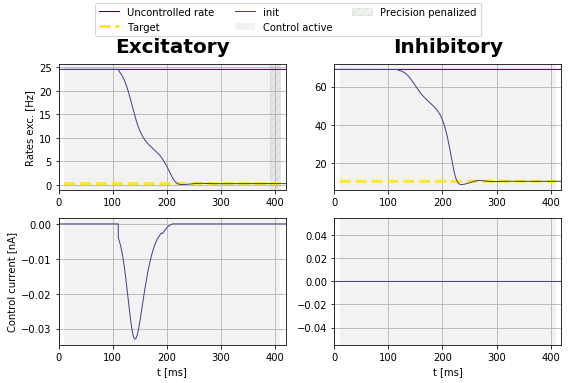

--------- 2


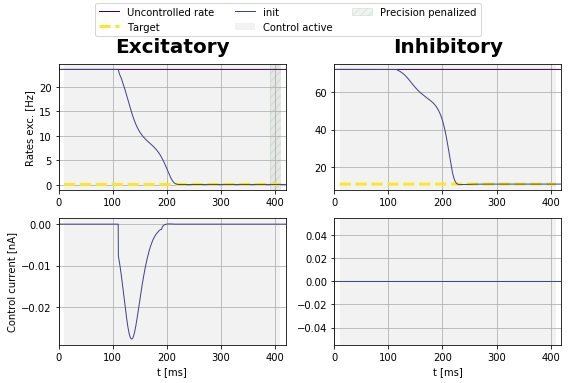

--------- 4


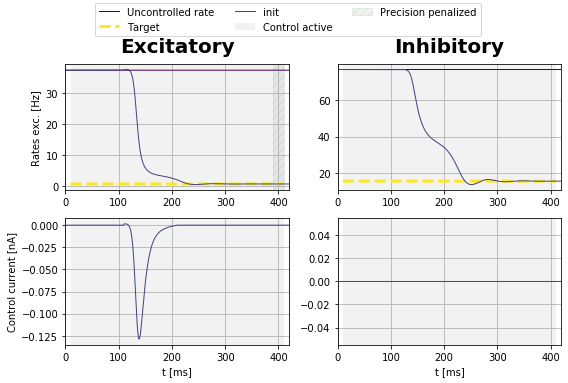

--------- 6


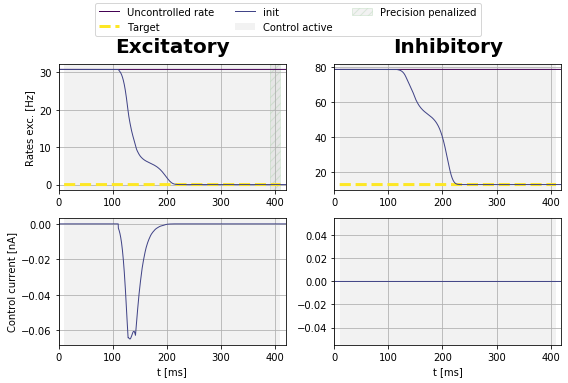

--------- 8


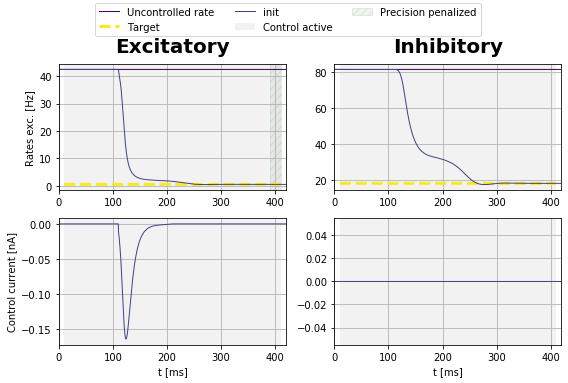

--------- 10


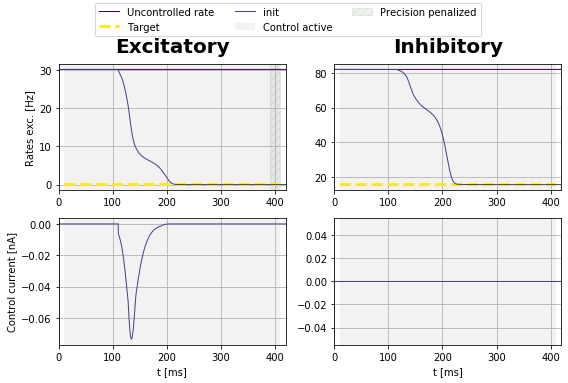

--------- 12


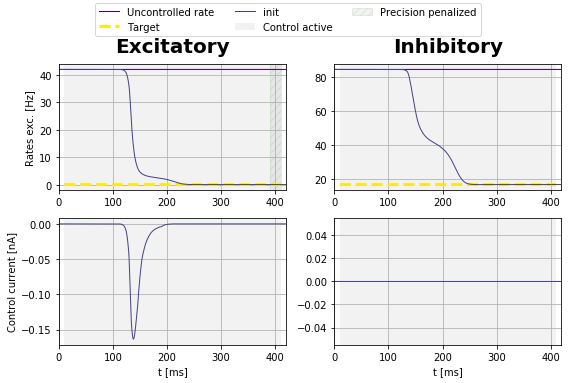

--------- 14


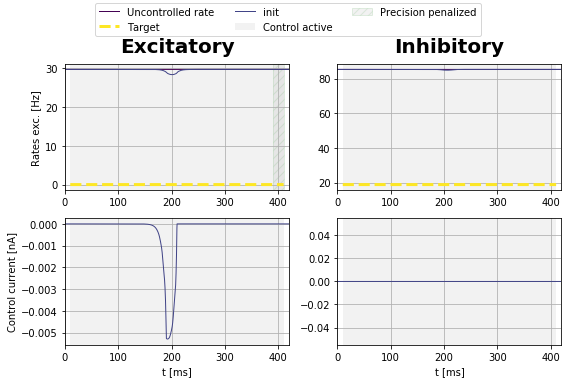

--------- 16


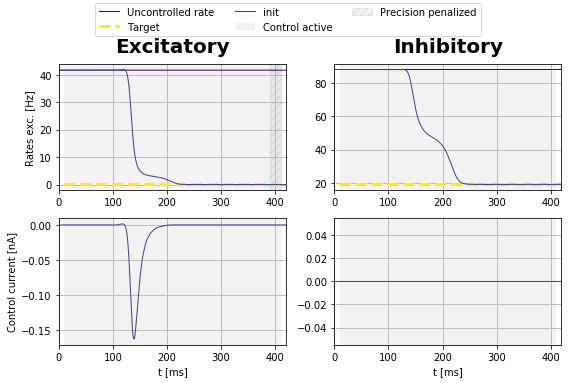

--------- 18


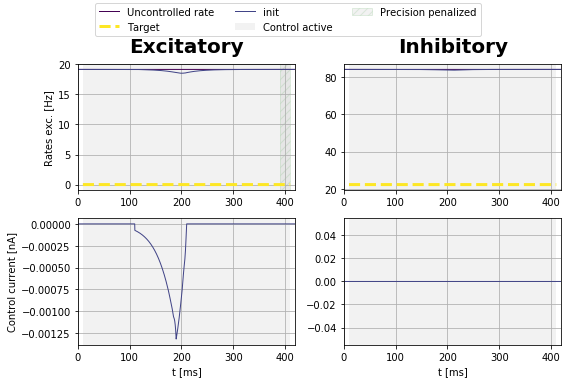

--------- 20


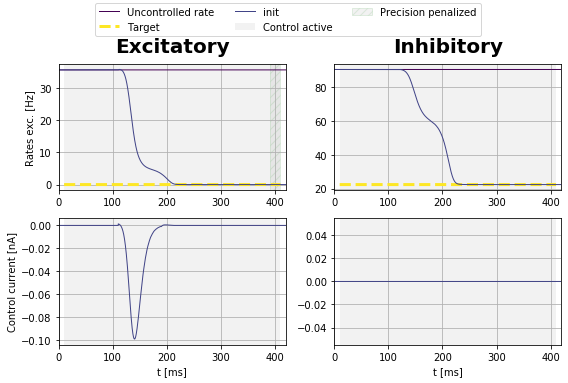

--------- 22


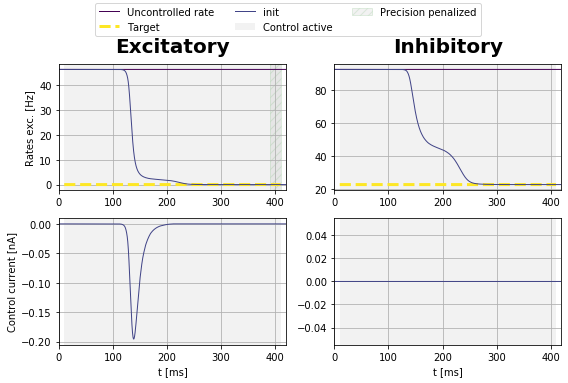

--------- 24


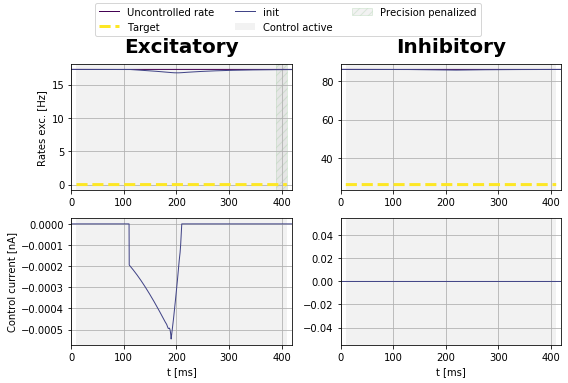

--------- 26


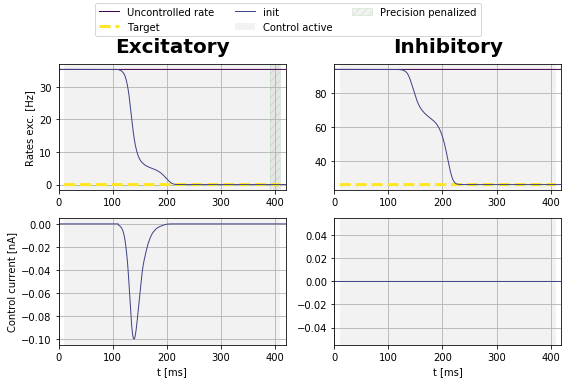

--------- 28


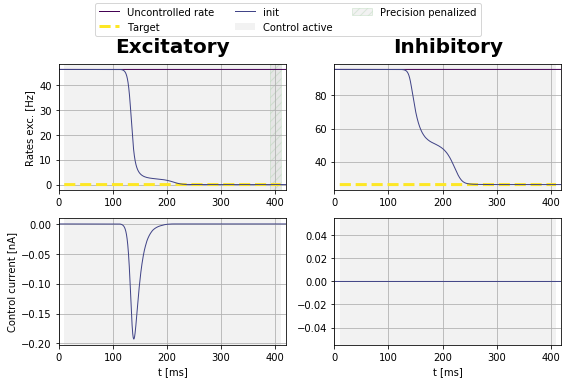

--------- 30


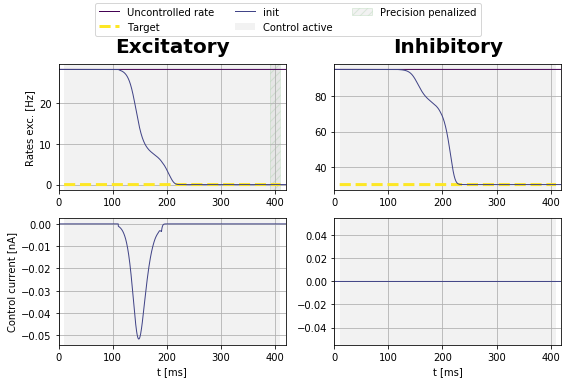

--------- 32


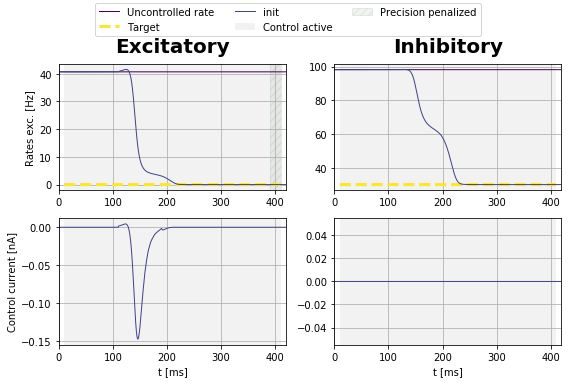

--------- 34


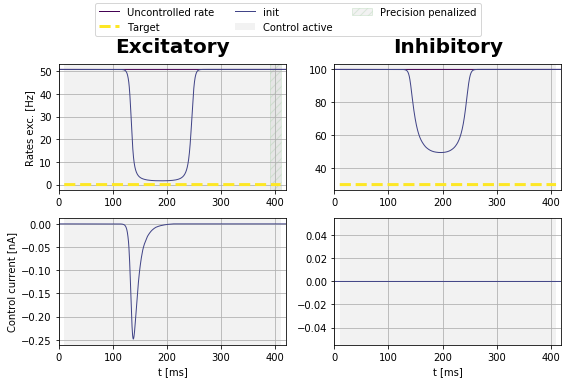

--------- 36


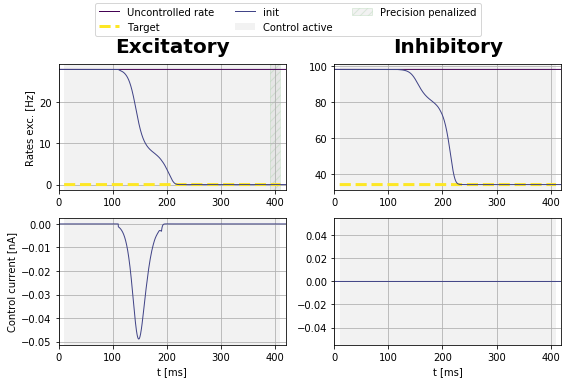

--------- 38


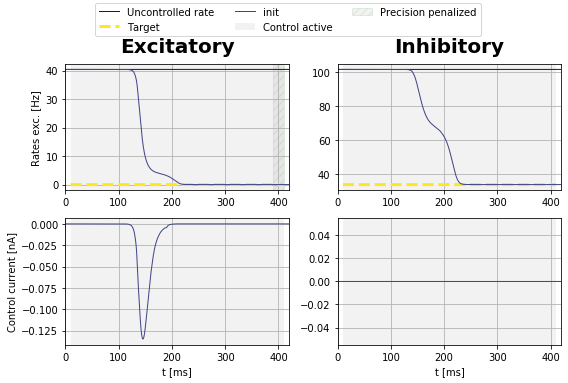

In [15]:

#plot initial guesses
for i in i_range:
    print("---------", i)
        
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    plotFunc.plot_control_current(aln, [bestControl_init[i]],
        [costnode_init[i]], [weights_init[i]], dur,
        dur_pre, dur_post, initVars[i], target[i], '', filename_ = '', transition_time_ = trans_time,
        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)
    plt.show()


In [16]:
found_solution = []
no_solution = []
factor_iteration = 20.

for i in i_range:
    print("------- ", i, exc[i], inh[i])    

    if np.abs(np.mean(bestState_init[i][0,0,-300:]) - target[i][0,0,-1]) < 0.1 * np.abs(
            np.mean(bestState_init[i][0,0,-100:]) - bestState_init[i][0,0,0]) and np.abs(
            np.mean(bestState_init[i][0,1,-100:]) - target[i][0,1,-1]) < 0.5 * np.abs(
            np.mean(bestState_init[i][0,1,-100:]) - bestState_init[i][0,1,0]) and np.amin(
            bestState_init[i][0,0,:]) > target[i][0,0,-1] - 5. and np.amin(
            bestState_init[i][0,1,:]) > target[i][0,1,-1] - 5.:
        # and np.amin(bestState_init[i][0,0,:]) > bestState_init[i][0,0,0] - 1.
        #and np.amin(bestState_init[i][0,1,:]) > bestState_init[i][0,1,0] - 1.:
        if i not in found_solution:
            print("found solution for ", i)
            found_solution.append(i)
        if i in no_solution:
            no_solution.pop(no_solution.index(i))
        

-------  0 0.4000000000000001 0.3500000000000001
found solution for  0
-------  2 0.4000000000000001 0.3750000000000001
found solution for  2
-------  4 0.4500000000000001 0.3750000000000001
found solution for  4
-------  6 0.4250000000000001 0.40000000000000013
found solution for  6
-------  8 0.47500000000000014 0.40000000000000013
found solution for  8
-------  10 0.4250000000000001 0.42500000000000016
found solution for  10
-------  12 0.47500000000000014 0.42500000000000016
found solution for  12
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
found solution for  16
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
found solution for  20
-------  22 0.5000000000000002 0.4750000000000002
found solution for  22
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
found solution for  26
-------  28 0.5000000000000002 0.5000000000000002


In [17]:
if os.path.isfile(final_file) :
    print("file found")
    
    with open(final_file,'rb') as f:
        load_array = pickle.load(f)

    bestControl_0 = load_array[0]
    bestState_0 = load_array[1]
    cost_0 = load_array[2]
    runtime_0 = load_array[3]
    grad_0 = load_array[4]
    phi_0 = load_array[5]
    costnode_0 = load_array[6]
    weights_0 = load_array[7]

file found


In [18]:
factor_iteration = 4
conv_0 = [[False]*2] * len(exc)
full_converge = False

for i in range(len(conv_0)):
    if i not in i_range_0:
        conv_0[i] = [True, True]

counter = 0

while full_converge == False:
    print('---------------', counter)
    
    if counter > 4:
        break
    
    print(conv_0[::i_stepsize])
    full_converge = True
    
    for conv in conv_0[::i_stepsize]:
        if not conv[0]:
            full_converge = False
            break
        if not conv[1]:
            full_converge = False
            break
    
    if full_converge:
        print("full convergence")
        break
        
    counter += 1
    
    for i in i_range_0:
        print("------- ", i, exc[i], inh[i])
        
        if conv_0[i] == [True, True]:
            continue
            
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.

    # exc and inh control current 

        setinit(initVars[i], aln)
        aln.params.duration = dur

        if not type(bestControl_0[i]) == type(None):
            control0 = bestControl_0[i][:,:,n_pre-1:-n_post+1]
        else:
            control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1].copy()
            weights_0[i] = weights_init[i]
            cost_0[i] = cost_init[i]

        cgv = None
        max_it = 500 * factor_iteration

        j = 1
        while cost_0[i][-j] == 0.:
            j += 1

        weight_ = (factor_we * weights_0[i][1] * cost_uncontrolled[i] / cost_0[i][-j]
                           + factor_ws * weights_0[i][2] * cost_uncontrolled[i] / cost_0[i][-j]) - 1
        print("weight = ", weight_)
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        weights_0[i] = cost.getParams()

        bestControl_0[i], bestState_0[i], cost_0[i], runtime_0[i], grad_0[i], phi_0[i], costnode_0[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_0,
            prec_variables_ = prec_vars, transition_time_ = trans_time)

        with open(final_file,'wb') as f:
            pickle.dump([bestControl_0, bestState_0, cost_0, runtime_0, grad_0, phi_0,
                     costnode_0, weights_0], f)
            
        if j == cost_0[i].shape[0]-1:
            print("converged for ", i)
            if conv_0[i][0]:
                conv_0[i] = [True, True]
            else:
                conv_0[i] = [True, False]
            continue
    
        print("no convergence")

--------------- 0
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [Tr

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5902.05169118709
Control only changes marginally.
RUN  1 , total integrated cost =  5902.05169118709
Improved over  1  iterations in  11.282748400000003  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -62.75143574455205 -62.75219846872262
converged for  0
-------  2 0.4000000000000001 0.3750000000000001
weight =  22299.37088937185
set cost params:  1.0 22299.37088937185 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5538.459393752772
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5538.459393752772
Control only changes marginally.
RUN  1 , total integrated cost =  5538.459393752772
Improved over  1  iterations in  0.4169509999999974  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -65.95812011095256 -65.95480842921747
converged for  2
-------  4 0.4500000000000001 0.3750000000000001
weight =  4494.523647368353
set cost params:  1.0 4494.523647368353 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13599.240889500794
Gradient descend method:  None
RUN  1 , total integrated cost =  13599.240826794665
RUN  2 , total integrated cost =  13599.240754755889
RUN  3 , total integrated cost =  13599.24067170788
RUN  4 , total integrated cost =  13599.240600405408
RUN  5 , total integrated cost =  13599.240521869806
RUN  6 , total integrated cost =  13599.240450074762
RUN  7 , total integrated cost =  13599.240387373055
RUN  8 , total integrated cost =  13599.240315335428
RUN  9 , total int

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  13599.095055591579
RUN  2000 , total integrated cost =  13599.095055591579
Improved over  2000  iterations in  338.23352689999996  seconds by  0.0010723680123021495  percent.
Problem in initial value trasfer:  Vmean_exc -61.76888176052528 -61.76912574988608
no convergence
-------  6 0.4250000000000001 0.40000000000000013
weight =  7865.007303909049
set cost params:  1.0 7865.007303909049 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9437.876753678023
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9437.876753678023
Control only changes marginally.
RUN  1 , total integrated cost =  9437.876753678023
Improved over  1  iterations in  0.40732619999999997  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -66.06663615406057 -66.06648035329431
converged for  6
-------  8 0.47500000000000014 0.40000000000000013
weight =  3606.1252192269008
set cost params:  1.0 3606.1252192269008 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17546.282134480505
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17546.282134480505
Control only changes marginally.
RUN  1 , total integrated cost =  17546.282134480505
Improved over  1  iterations in  0.40955040000000054  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.628707657994724 -61.62844584479332
converged for  8
-------  10 0.4250000000000001 0.42500000000000016
weight =  132918.29823822502
set cost params:  1.0 132918.29823822502 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8956.309552120108
Gradient descend method:  None
RUN  1 , total integrated cost =  8956.262049230907
RUN  2 , total integrated cost =  8956.262049230905


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  8956.262049230905
Control only changes marginally.
RUN  3 , total integrated cost =  8956.262049230905
Improved over  3  iterations in  1.015862899999945  seconds by  0.0005303846291440095  percent.
Problem in initial value trasfer:  Vmean_exc -56.64504324513636 -56.645081902116225
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  3812.2151224705713
set cost params:  1.0 3812.2151224705713 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17566.592191237713
Gradient descend method:  None
RUN  1 , total integrated cost =  17566.592190844818
RUN  2 , total integrated cost =  17566.59219046848
RUN  3 , total integrated cost =  17566.59219007549
RUN  4 , total integrated cost =  17566.592189699113
RUN  5 , total integrated cost =  17566.59218930617
RUN  6 , total integrated cost =  17566.59218892986
RUN  7 , total integrated cost =  17566.592188536903
RUN  8 , total integrated cost =  17566.592188160572


ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  17566.59142130764
RUN  2000 , total integrated cost =  17566.59142130764
Improved over  2000  iterations in  314.6873525  seconds by  4.382922227819108e-06  percent.
Problem in initial value trasfer:  Vmean_exc -63.98771866969875 -63.98759531234596
no convergence
-------  14 0.4250000000000001 0.4500000000000002
weight =  92156.52244308204
set cost params:  1.0 92156.52244308204 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8574.465079302638
Gradient descend method:  None
RUN  1 , total integrated cost =  8574.311913754069
RUN  2 , total integrated cost =  8574.311913754065
RUN  3 , total integrated cost =  8574.311913754063
State only changes marginally.


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  8574.311913754063
Control only changes marginally.
RUN  4 , total integrated cost =  8574.311913754063
Improved over  4  iterations in  1.283315299999913  seconds by  0.0017862985872199033  percent.
Problem in initial value trasfer:  Vmean_exc -56.64196766870936 -56.642020257089776
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  3957.7065388635133
set cost params:  1.0 3957.7065388635133 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17336.517509696674
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17336.517509696674
Control only changes marginally.
RUN  1 , total integrated cost =  17336.517509696674
Improved over  1  iterations in  0.41142360000003464  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -66.22017075800086 -66.22086928295028
converged for  16
-------  18 0.4000000000000001 0.4750000000000002
weight =  343683.318227589
set cost params:  1.0 343683.318227589 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3593.534176304163
Gradient descend method:  None
RUN  1 , total integrated cost =  3593.4945684911886
RUN  2 , total integrated cost =  3593.494568491186
RUN  3 , total integrated cost =  3593.494568491184


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  3593.494568491184
Control only changes marginally.
RUN  4 , total integrated cost =  3593.494568491184
Improved over  4  iterations in  1.200904400000013  seconds by  0.0011021966408435446  percent.
Problem in initial value trasfer:  Vmean_exc -56.63637082777905 -56.636357416648025
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  5551.673692789395
set cost params:  1.0 5551.673692789395 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12735.822399304976
Gradient descend method:  None
RUN  1 , total integrated cost =  12735.822395784482
RUN  2 , total integrated cost =  12735.822391642047
RUN  3 , total integrated cost =  12735.822388121385
RUN  4 , total integrated cost =  12735.822383977178
RUN  5 , total integrated cost =  12735.822380455982
RUN  6 , total integrated cost =  12735.822376313343
RUN  7 , total integrated cost =  12735.822372791456
RUN  8 , total integrated cost =  12735.822368648594


ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  12735.8147374658
RUN  2000 , total integrated cost =  12735.8147374658
Improved over  2000  iterations in  348.06092950000004  seconds by  6.01597520528685e-05  percent.
Problem in initial value trasfer:  Vmean_exc -69.75462714079512 -69.76035527194767
no convergence
-------  22 0.5000000000000002 0.4750000000000002
weight =  3304.464121154761
set cost params:  1.0 3304.464121154761 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21558.653488576925
Gradient descend method:  None
RUN  1 , total integrated cost =  21558.653486703435
RUN  2 , total integrated cost =  21558.653484489238
RUN  3 , total integrated cost =  21558.653479464618
RUN  4 , total integrated cost =  21558.653474277155
RUN  5 , total integrated cost =  21558.653472397982
RUN  6 , total integrated cost =  21558.653470197565
RUN  7 , total integrated cost =  21558.653465060983
RUN  8 , total integrated cost =  21558.65345999538
RUN  9 , total integrated co

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  21558.64638456747
RUN  2000 , total integrated cost =  21558.64638456747
Improved over  2000  iterations in  330.3863007  seconds by  3.295200907871276e-05  percent.
Problem in initial value trasfer:  Vmean_exc -65.70179607486162 -65.702867155908
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  943100.3488552303
set cost params:  1.0 943100.3488552303 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2927.5915217044108
Gradient descend method:  None
RUN  1 , total integrated cost =  2927.570520185443
RUN  2 , total integrated cost =  2927.5705063090377
RUN  3 , total integrated cost =  2927.5705063083274
RUN  4 , total integrated cost =  2927.570506308321
RUN  5 , total integrated cost =  2927.570506308318


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  2927.570506308318
Control only changes marginally.
RUN  6 , total integrated cost =  2927.570506308318
Improved over  6  iterations in  1.4694332999999915  seconds by  0.0007178390816164892  percent.
Problem in initial value trasfer:  Vmean_exc -56.656322583754616 -56.656315028172806
no convergence
-------  26 0.4500000000000001 0.5000000000000002
weight =  5752.511492427074
set cost params:  1.0 5752.511492427074 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12477.515558163674
Gradient descend method:  None
RUN  1 , total integrated cost =  12477.51555677583
RUN  2 , total integrated cost =  12477.51555422586
RUN  3 , total integrated cost =  12477.515552838191
RUN  4 , total integrated cost =  12477.51555028851
RUN  5 , total integrated cost =  12477.515548900401
RUN  6 , total integrated cost =  12477.515546350898
RUN  7 , total integrated cost =  12477.515544962873
RUN  8 , total integrated cost =  12477.51554241311
RU

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  12477.511620679383
RUN  2000 , total integrated cost =  12477.511620679383
Improved over  2000  iterations in  362.52916600000003  seconds by  3.155663699772049e-05  percent.
Problem in initial value trasfer:  Vmean_exc -71.15667310904259 -71.16385485124141
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  3374.4967487861036
set cost params:  1.0 3374.4967487861036 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21306.77872084231
Gradient descend method:  None
RUN  1 , total integrated cost =  21306.77872057695
RUN  2 , total integrated cost =  21306.778720306043
RUN  3 , total integrated cost =  21306.778720046153
RUN  4 , total integrated cost =  21306.778719764065
RUN  5 , total integrated cost =  21306.77871951908
RUN  6 , total integrated cost =  21306.77871923305
RUN  7 , total integrated cost =  21306.77871896295
RUN  8 , total integrated cost =  21306.778718649894
RUN  9 , total integrated

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  21306.77818605552
RUN  2000 , total integrated cost =  21306.77818605552
Improved over  2000  iterations in  329.6083099  seconds by  2.509937331751644e-06  percent.
Problem in initial value trasfer:  Vmean_exc -67.2856583267283 -67.28751571788034
no convergence
-------  30 0.4250000000000001 0.5250000000000002
weight =  11634.40620103941
set cost params:  1.0 11634.40620103941 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7977.631488734322
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7977.631488734322
Control only changes marginally.
RUN  1 , total integrated cost =  7977.631488734322
Improved over  1  iterations in  0.4145576999999321  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -72.92340530546203 -72.9405089305008
converged for  30
-------  32 0.47500000000000014 0.5250000000000002
weight =  4256.749223222063
set cost params:  1.0 4256.749223222063 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16564.327070523126
Gradient descend method:  None
RUN  1 , total integrated cost =  16564.32706919969
RUN  2 , total integrated cost =  16564.327067011447
RUN  3 , total integrated cost =  16564.32706568907
RUN  4 , total integrated cost =  16564.327063498422
RUN  5 , total integrated cost =  16564.327062175013
RUN  6 , total integrated cost =  16564.327059986786
RUN  7 , total integrated cost =  16564.327058664436
RUN  8 , total integrated cost =  16564.3270564737
RUN  9 , total inte

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  16564.32355709942
RUN  2000 , total integrated cost =  16564.32355709942
Improved over  2000  iterations in  315.79150819999995  seconds by  2.1210784424852136e-05  percent.
Problem in initial value trasfer:  Vmean_exc -70.33671773191989 -70.34267021678141
no convergence
-------  34 0.5250000000000001 0.5250000000000002
weight =  21196.480733795255
set cost params:  1.0 21196.480733795255 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  24253.505044772486
Gradient descend method:  None
RUN  1 , total integrated cost =  24247.070173787983
RUN  2 , total integrated cost =  24247.070173787975
RUN  3 , total integrated cost =  24247.070173787968
RUN  4 , total integrated cost =  24247.070173787964


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  24247.070173787964
Control only changes marginally.
RUN  5 , total integrated cost =  24247.070173787964
Improved over  5  iterations in  1.5593370999999934  seconds by  0.02653171561240697  percent.
Problem in initial value trasfer:  Vmean_exc -56.70155846539136 -56.701689692777265
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  12524.937663166562
set cost params:  1.0 12524.937663166562 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7741.049682325693
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7741.049682325693
Control only changes marginally.
RUN  1 , total integrated cost =  7741.049682325693
Improved over  1  iterations in  0.46951020000005883  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -73.51734318302758 -73.53702868940019
converged for  36
-------  38 0.47500000000000014 0.5500000000000003
weight =  4356.351243617474
set cost params:  1.0 4356.351243617474 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16340.877147474084
Gradient descend method:  None
RUN  1 , total integrated cost =  16340.877147465291
RUN  2 , total integrated cost =  16340.877147448882
RUN  3 , total integrated cost =  16340.877147434532
RUN  4 , total integrated cost =  16340.877147406833
RUN  5 , total integrated cost =  16340.877147380257
RUN  6 , total integrated cost =  16340.877147366557
RUN  7 , total integrated cost =  16340.877147352952
RUN  8 , total integrated cost =  16340.87714732031
RUN  9 , total

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  16340.877114572186
RUN  2000 , total integrated cost =  16340.877114572186
Improved over  2000  iterations in  340.56542739999986  seconds by  2.0134719136422063e-07  percent.
Problem in initial value trasfer:  Vmean_exc -71.0865400290988 -71.09439062401026
no convergence
--------------- 1
[[True, False], [True, False], [False, False], [True, False], [True, False], [False, False], [False, False], [False, False], [True, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, False], [False, False], [False, False], [True, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, T

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5902.0516911870845
Control only changes marginally.
RUN  1 , total integrated cost =  5902.0516911870845
Improved over  1  iterations in  0.4128875999999764  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -62.75143574455205 -62.75219846872262
converged for  0
-------  2 0.4000000000000001 0.3750000000000001
weight =  22299.37088937185
set cost params:  1.0 22299.37088937185 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5538.459393752772
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5538.459393752772
Control only changes marginally.
RUN  1 , total integrated cost =  5538.459393752772
Improved over  1  iterations in  0.41913079999994807  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -65.95812011095256 -65.95480842921747
converged for  2
-------  4 0.4500000000000001 0.3750000000000001
weight =  4494.571856468751
set cost params:  1.0 4494.571856468751 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13599.24092194898
Gradient descend method:  None
RUN  1 , total integrated cost =  13599.240839741142
RUN  2 , total integrated cost =  13599.240768973217
RUN  3 , total integrated cost =  13599.24069119928
RUN  4 , total integrated cost =  13599.240619877792
RUN  5 , total integrated cost =  13599.240557789693
RUN  6 , total integrated cost =  13599.240486269971
RUN  7 , total integrated cost =  13599.240404067725
RUN  8 , total integrated cost =  13599.240333300988
RUN  9 , total int

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  13599.088599277598
RUN  2000 , total integrated cost =  13599.088599277598
Improved over  2000  iterations in  317.47139860000016  seconds by  0.0011200821594172794  percent.
Problem in initial value trasfer:  Vmean_exc -61.76880909486079 -61.76905662705608
no convergence
-------  6 0.4250000000000001 0.40000000000000013
weight =  7865.007303909049
set cost params:  1.0 7865.007303909049 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9437.876753678023
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9437.876753678023
Control only changes marginally.
RUN  1 , total integrated cost =  9437.876753678023
Improved over  1  iterations in  0.4271020999999564  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -66.06663615406057 -66.06648035329431
converged for  6
-------  8 0.47500000000000014 0.40000000000000013
weight =  3606.1252192269
set cost params:  1.0 3606.1252192269 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17546.282134480498
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17546.282134480498
Control only changes marginally.
RUN  1 , total integrated cost =  17546.282134480498
Improved over  1  iterations in  0.46667999999999665  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.628707657994724 -61.62844584479332
converged for  8
-------  10 0.4250000000000001 0.42500000000000016
weight =  135220.51144008362
set cost params:  1.0 135220.51144008362 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8958.922438152513
Gradient descend method:  None
RUN  1 , total integrated cost =  8958.878141254434
RUN  2 , total integrated cost =  8958.878141254429
RUN  3 , total integrated cost =  8958.878141254427


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  8958.878141254427
Control only changes marginally.
RUN  4 , total integrated cost =  8958.878141254427
Improved over  4  iterations in  1.226357999999891  seconds by  0.0004944444869465769  percent.
Problem in initial value trasfer:  Vmean_exc -56.64506891577263 -56.64510691179792
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  3812.2152896008374
set cost params:  1.0 3812.2152896008374 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17566.592191439693
Gradient descend method:  None
RUN  1 , total integrated cost =  17566.592191046864
RUN  2 , total integrated cost =  17566.59219067053
RUN  3 , total integrated cost =  17566.592190277726
RUN  4 , total integrated cost =  17566.592189901457
RUN  5 , total integrated cost =  17566.592189508545
RUN  6 , total integrated cost =  17566.59218913239
RUN  7 , total integrated cost =  17566.59218873951
RUN  8 , total integrated cost =  17566.592188363204


ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  17566.591420712266
RUN  2000 , total integrated cost =  17566.591420712266
Improved over  2000  iterations in  318.37900320000017  seconds by  4.387461260080272e-06  percent.
Problem in initial value trasfer:  Vmean_exc -63.9877187124153 -63.987595355209926
no convergence
-------  14 0.4250000000000001 0.4500000000000002
weight =  94540.10821095793
set cost params:  1.0 94540.10821095793 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8579.97932999891
Gradient descend method:  None
RUN  1 , total integrated cost =  8579.849172729364
RUN  2 , total integrated cost =  8579.84917272936
RUN  3 , total integrated cost =  8579.849172729359


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  8579.849172729359
Control only changes marginally.
RUN  4 , total integrated cost =  8579.849172729359
Improved over  4  iterations in  1.2335145999995802  seconds by  0.0015169881481824632  percent.
Problem in initial value trasfer:  Vmean_exc -56.64201937549868 -56.64207072956304
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  3957.7065388635133
set cost params:  1.0 3957.7065388635133 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17336.517509696674
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17336.517509696674
Control only changes marginally.
RUN  1 , total integrated cost =  17336.517509696674
Improved over  1  iterations in  0.46297839999988355  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -66.22017075800086 -66.22086928295028
converged for  16
-------  18 0.4000000000000001 0.4750000000000002
weight =  351110.20019121876
set cost params:  1.0 351110.20019121876 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3595.2042150895854
Gradient descend method:  None
RUN  1 , total integrated cost =  3595.1695295789323
RUN  2 , total integrated cost =  3595.1695287237594
RUN  3 , total integrated cost =  3595.1695287237435
RUN  4 , total integrated cost =  3595.1695287237417


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  3595.1695287237417
Control only changes marginally.
RUN  5 , total integrated cost =  3595.1695287237417
Improved over  5  iterations in  1.251504400000158  seconds by  0.0009647954265972203  percent.
Problem in initial value trasfer:  Vmean_exc -56.636300749487674 -56.63628760490159
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  5551.677033266144
set cost params:  1.0 5551.677033266144 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12735.822400685054
Gradient descend method:  None
RUN  1 , total integrated cost =  12735.82239716744
RUN  2 , total integrated cost =  12735.822393022816
RUN  3 , total integrated cost =  12735.822389504152
RUN  4 , total integrated cost =  12735.822385362673
RUN  5 , total integrated cost =  12735.822381845299
RUN  6 , total integrated cost =  12735.822377700772
RUN  7 , total integrated cost =  12735.822374184412
RUN  8 , total integrated cost =  12735.822370040583

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  12735.814741439948
RUN  2000 , total integrated cost =  12735.814741439948
Improved over  2000  iterations in  348.7135581000002  seconds by  6.013938373428118e-05  percent.
Problem in initial value trasfer:  Vmean_exc -69.75456720175916 -69.76029562197986
no convergence
-------  22 0.5000000000000002 0.4750000000000002
weight =  3304.4652103719986
set cost params:  1.0 3304.4652103719986 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21558.653490726756
Gradient descend method:  None
RUN  1 , total integrated cost =  21558.65348886102
RUN  2 , total integrated cost =  21558.653486680458
RUN  3 , total integrated cost =  21558.65348145685
RUN  4 , total integrated cost =  21558.65347579187
RUN  5 , total integrated cost =  21558.653473839968
RUN  6 , total integrated cost =  21558.653471316706
RUN  7 , total integrated cost =  21558.653467308788
RUN  8 , total integrated cost =  21558.653463192953
RUN  9 , total integrate

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  21558.646827873778
RUN  2000 , total integrated cost =  21558.646827873778
Improved over  2000  iterations in  331.68987620000007  seconds by  3.090570095309886e-05  percent.
Problem in initial value trasfer:  Vmean_exc -65.70127734609063 -65.70235101710801
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  960305.4388831208
set cost params:  1.0 960305.4388831208 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2928.6071512696376
Gradient descend method:  None
RUN  1 , total integrated cost =  2928.5874419607044
RUN  2 , total integrated cost =  2928.5874419607003
RUN  3 , total integrated cost =  2928.5874419606967
RUN  4 , total integrated cost =  2928.5874419606953
RUN  5 , total integrated cost =  2928.587441960695


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  2928.587441960695
Control only changes marginally.
RUN  6 , total integrated cost =  2928.587441960695
Improved over  6  iterations in  1.650277300000198  seconds by  0.0006729925840005535  percent.
Problem in initial value trasfer:  Vmean_exc -56.65622440584897 -56.65621698216
no convergence
-------  26 0.4500000000000001 0.5000000000000002
weight =  5752.513308042401
set cost params:  1.0 5752.513308042401 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12477.515558848163
Gradient descend method:  None
RUN  1 , total integrated cost =  12477.515557460169
RUN  2 , total integrated cost =  12477.515554910808
RUN  3 , total integrated cost =  12477.515553523068
RUN  4 , total integrated cost =  12477.515550973405
RUN  5 , total integrated cost =  12477.51554958588
RUN  6 , total integrated cost =  12477.515547036228
RUN  7 , total integrated cost =  12477.515545648605
RUN  8 , total integrated cost =  12477.515543099034
RUN  

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  12477.511621682548
RUN  2000 , total integrated cost =  12477.511621682548
Improved over  2000  iterations in  352.63616020000063  seconds by  3.155408299448936e-05  percent.
Problem in initial value trasfer:  Vmean_exc -71.15667645890564 -71.16385818521128
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  3374.4968335089625
set cost params:  1.0 3374.4968335089625 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21306.778721000803
Gradient descend method:  None
RUN  1 , total integrated cost =  21306.778720736016
RUN  2 , total integrated cost =  21306.778720465183
RUN  3 , total integrated cost =  21306.778720205366
RUN  4 , total integrated cost =  21306.77871992447
RUN  5 , total integrated cost =  21306.77871967982
RUN  6 , total integrated cost =  21306.778719394093
RUN  7 , total integrated cost =  21306.778719124228
RUN  8 , total integrated cost =  21306.77871881226
RUN  9 , total integrat

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  21306.778184798783
RUN  2000 , total integrated cost =  21306.778184798783
Improved over  2000  iterations in  335.6314486000001  seconds by  2.5165794852455292e-06  percent.
Problem in initial value trasfer:  Vmean_exc -67.28565028840727 -67.28750771896037
no convergence
-------  30 0.4250000000000001 0.5250000000000002
weight =  11634.40620103941
set cost params:  1.0 11634.40620103941 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7977.631488734322
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7977.631488734322
Control only changes marginally.
RUN  1 , total integrated cost =  7977.631488734322
Improved over  1  iterations in  0.4134507999997368  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -72.92340530546203 -72.9405089305008
converged for  30
-------  32 0.47500000000000014 0.5250000000000002
weight =  4256.750126324243
set cost params:  1.0 4256.750126324243 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16564.327071348413
Gradient descend method:  None
RUN  1 , total integrated cost =  16564.32707002481
RUN  2 , total integrated cost =  16564.327067838014
RUN  3 , total integrated cost =  16564.327066516613
RUN  4 , total integrated cost =  16564.327064324676
RUN  5 , total integrated cost =  16564.327063001117
RUN  6 , total integrated cost =  16564.327060814463
RUN  7 , total integrated cost =  16564.32705949313
RUN  8 , total integrated cost =  16564.32705730107
RUN  9 , total int

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  16564.32355848284
RUN  2000 , total integrated cost =  16564.32355848284
Improved over  2000  iterations in  313.72575770000003  seconds by  2.120741493172318e-05  percent.
Problem in initial value trasfer:  Vmean_exc -70.33663988702904 -70.34259274161126
no convergence
-------  34 0.5250000000000001 0.5250000000000002
weight =  22517.79404244243
set cost params:  1.0 22517.79404244243 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  24337.723015723237
Gradient descend method:  None
RUN  1 , total integrated cost =  24332.896945166816
RUN  2 , total integrated cost =  24332.896945166794
RUN  3 , total integrated cost =  24332.896945166787
RUN  4 , total integrated cost =  24332.896945166784


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  24332.896945166784
Control only changes marginally.
RUN  5 , total integrated cost =  24332.896945166784
Improved over  5  iterations in  1.4151370999998107  seconds by  0.019829589453934204  percent.
Problem in initial value trasfer:  Vmean_exc -56.701655838628994 -56.70178019569444
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  12524.937663166562
set cost params:  1.0 12524.937663166562 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7741.049682325693
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7741.049682325693
Control only changes marginally.
RUN  1 , total integrated cost =  7741.049682325693
Improved over  1  iterations in  0.41648910000003525  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -73.51734318302758 -73.53702868940019
converged for  36
-------  38 0.47500000000000014 0.5500000000000003
weight =  4356.351252390884
set cost params:  1.0 4356.351252390884 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16340.877147481646
Gradient descend method:  None
RUN  1 , total integrated cost =  16340.877147467329
RUN  2 , total integrated cost =  16340.877147438772
RUN  3 , total integrated cost =  16340.877147407728
RUN  4 , total integrated cost =  16340.877147371519
RUN  5 , total integrated cost =  16340.877147335279
RUN  6 , total integrated cost =  16340.877147323605
RUN  7 , total integrated cost =  16340.87714730999
RUN  8 , total integrated cost =  16340.877147300584
RUN  9 , total

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  16340.877114794246
RUN  2000 , total integrated cost =  16340.877114794246
Improved over  2000  iterations in  344.3249671000003  seconds by  2.0003454892503214e-07  percent.
Problem in initial value trasfer:  Vmean_exc -71.08981331258177 -71.09764841677648
no convergence
--------------- 2
[[True, True], [True, True], [False, False], [True, True], [True, True], [False, False], [False, False], [False, False], [True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [False, False], [False, False], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  13599.088108594575
RUN  2000 , total integrated cost =  13599.088108594575
Improved over  2000  iterations in  319.32242399999996  seconds by  0.0011239395026336751  percent.
Problem in initial value trasfer:  Vmean_exc -61.76880850706211 -61.76905610270173
no convergence
-------  6 0.4250000000000001 0.40000000000000013
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
weight =  137522.4473719356
set cost params:  1.0 137522.4473719356 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8961.446408655973
Gradient descend method:  None
RUN  1 , total integrated cost =  8961.40707610241
RUN  2 , total integrated cost =  8961.4070761024
RUN  3 , total integrated cost =  8961.407076102394


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  8961.407076102394
Control only changes marginally.
RUN  4 , total integrated cost =  8961.407076102394
Improved over  4  iterations in  1.1381982000002608  seconds by  0.0004389085398059933  percent.
Problem in initial value trasfer:  Vmean_exc -56.645092120168954 -56.64512951827689
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  3812.21545690419
set cost params:  1.0 3812.21545690419 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17566.592191641856
Gradient descend method:  None
RUN  1 , total integrated cost =  17566.59219124918
RUN  2 , total integrated cost =  17566.59219087296
RUN  3 , total integrated cost =  17566.59219048024
RUN  4 , total integrated cost =  17566.592190104002
RUN  5 , total integrated cost =  17566.59218971129
RUN  6 , total integrated cost =  17566.592189335046
RUN  7 , total integrated cost =  17566.59218894233
RUN  8 , total integrated cost =  17566.59218856613
RUN  

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  17566.59142252752
RUN  2000 , total integrated cost =  17566.59142252752
Improved over  2000  iterations in  314.2158239999999  seconds by  4.378278532612967e-06  percent.
Problem in initial value trasfer:  Vmean_exc -63.98771875318156 -63.98759539611687
no convergence
-------  14 0.4250000000000001 0.4500000000000002
weight =  96922.77716779907
set cost params:  1.0 96922.77716779907 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8585.244294610184
Gradient descend method:  None
RUN  1 , total integrated cost =  8585.116034010081
RUN  2 , total integrated cost =  8585.116034010067


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  8585.116034010067
Control only changes marginally.
RUN  3 , total integrated cost =  8585.116034010067
Improved over  3  iterations in  0.9807565000000977  seconds by  0.0014939656428651915  percent.
Problem in initial value trasfer:  Vmean_exc -56.64207122222767 -56.642121336279374
no convergence
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
weight =  358530.48145096307
set cost params:  1.0 358530.48145096307 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3596.807134740836
Gradient descend method:  None
RUN  1 , total integrated cost =  3596.7725003183655
RUN  2 , total integrated cost =  3596.77250031836
RUN  3 , total integrated cost =  3596.7725003183564
RUN  4 , total integrated cost =  3596.772500318356
State only changes marginally.
RUN  5 , total integrated cost =  3596.7725003183555
State only changes marginally.


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  3596.7725003183555
Control only changes marginally.
RUN  6 , total integrated cost =  3596.7725003183555
Improved over  6  iterations in  1.7262442000001101  seconds by  0.0009629213127908542  percent.
Problem in initial value trasfer:  Vmean_exc -56.63623079557864 -56.63621791802867
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  5551.680372613921
set cost params:  1.0 5551.680372613921 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12735.822402064656
Gradient descend method:  None
RUN  1 , total integrated cost =  12735.822398546743
RUN  2 , total integrated cost =  12735.822394400238
RUN  3 , total integrated cost =  12735.82239088209
RUN  4 , total integrated cost =  12735.822386744647
RUN  5 , total integrated cost =  12735.822383216979
RUN  6 , total integrated cost =  12735.822379083489
RUN  7 , total integrated cost =  12735.822375566888
RUN  8 , total integrated cost =  12735.822371419688

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  12735.814745489508
RUN  2000 , total integrated cost =  12735.814745489508
Improved over  2000  iterations in  349.1240693999998  seconds by  6.011841958297737e-05  percent.
Problem in initial value trasfer:  Vmean_exc -69.75460349843263 -69.76033174360522
no convergence
-------  22 0.5000000000000002 0.4750000000000002
weight =  3304.466231949548
set cost params:  1.0 3304.466231949548 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21558.65349274324
Gradient descend method:  None
RUN  1 , total integrated cost =  21558.653487579206
RUN  2 , total integrated cost =  21558.653482689893
RUN  3 , total integrated cost =  21558.65348083383
RUN  4 , total integrated cost =  21558.653478680186
RUN  5 , total integrated cost =  21558.6534734027
RUN  6 , total integrated cost =  21558.653467871834
RUN  7 , total integrated cost =  21558.653465959207
RUN  8 , total integrated cost =  21558.653463671646
RUN  9 , total integrated c

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  21558.646879184365
RUN  2000 , total integrated cost =  21558.646879184365
Improved over  2000  iterations in  328.1607279  seconds by  3.067704983550357e-05  percent.
Problem in initial value trasfer:  Vmean_exc -65.70190450994876 -65.70297504919225
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  977484.8772019316
set cost params:  1.0 977484.8772019316 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2929.5828965348537
Gradient descend method:  None
RUN  1 , total integrated cost =  2929.56459873101
RUN  2 , total integrated cost =  2929.564598731002
RUN  3 , total integrated cost =  2929.564598731
RUN  4 , total integrated cost =  2929.5645987309995


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  2929.5645987309995
Control only changes marginally.
RUN  5 , total integrated cost =  2929.5645987309995
Improved over  5  iterations in  1.5092300999995132  seconds by  0.000624587338890592  percent.
Problem in initial value trasfer:  Vmean_exc -56.65612756844688 -56.656120275693034
no convergence
-------  26 0.4500000000000001 0.5000000000000002
weight =  5752.515123511352
set cost params:  1.0 5752.515123511352 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12477.515559532625
Gradient descend method:  None
RUN  1 , total integrated cost =  12477.515558145085
RUN  2 , total integrated cost =  12477.515555595817
RUN  3 , total integrated cost =  12477.515554208307
RUN  4 , total integrated cost =  12477.51555165879
RUN  5 , total integrated cost =  12477.515550270826
RUN  6 , total integrated cost =  12477.515547721985
RUN  7 , total integrated cost =  12477.515546333547
RUN  8 , total integrated cost =  12477.515543784535

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  12477.511622671036
RUN  2000 , total integrated cost =  12477.511622671036
Improved over  2000  iterations in  360.6910124999995  seconds by  3.1551646401339895e-05  percent.
Problem in initial value trasfer:  Vmean_exc -71.15666143815305 -71.16384323572358
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  3374.4969184560273
set cost params:  1.0 3374.4969184560273 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21306.778721159604
Gradient descend method:  None
RUN  1 , total integrated cost =  21306.778720896888
RUN  2 , total integrated cost =  21306.778720623275
RUN  3 , total integrated cost =  21306.778720361173
RUN  4 , total integrated cost =  21306.778720086248
RUN  5 , total integrated cost =  21306.77871984436
RUN  6 , total integrated cost =  21306.77871955453
RUN  7 , total integrated cost =  21306.778719304166
RUN  8 , total integrated cost =  21306.77871903152
RUN  9 , total integrat

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  21306.77818766917
RUN  2000 , total integrated cost =  21306.77818766917
Improved over  2000  iterations in  326.69768880000083  seconds by  2.5038530822030225e-06  percent.
Problem in initial value trasfer:  Vmean_exc -67.28567266709939 -67.28752998795993
no convergence
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
weight =  4256.751029283173
set cost params:  1.0 4256.751029283173 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16564.32707217364
Gradient descend method:  None
RUN  1 , total integrated cost =  16564.327070829855
RUN  2 , total integrated cost =  16564.32706865861
RUN  3 , total integrated cost =  16564.32706732272
RUN  4 , total integrated cost =  16564.327065133828
RUN  5 , total integrated cost =  16564.32706381168
RUN  6 , total integrated cost =  16564.3270616225
RUN  7 , total integrated cost =  16564.327060300322
RUN  8 , total integrated cost 

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  16564.323559486544
RUN  2000 , total integrated cost =  16564.323559486544
Improved over  2000  iterations in  314.79597659999945  seconds by  2.1206337464718672e-05  percent.
Problem in initial value trasfer:  Vmean_exc -70.3367028265451 -70.34265538219898
no convergence
-------  34 0.5250000000000001 0.5250000000000002
weight =  23837.15631641669
set cost params:  1.0 23837.15631641669 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  24413.646915505542
Gradient descend method:  None
RUN  1 , total integrated cost =  24409.471401360162
RUN  2 , total integrated cost =  24409.471401360133


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  24409.471401360133
Control only changes marginally.
RUN  3 , total integrated cost =  24409.471401360133
Improved over  3  iterations in  0.9059170999998969  seconds by  0.017103197076039578  percent.
Problem in initial value trasfer:  Vmean_exc -56.701745181012036 -56.70186318427947
no convergence
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
weight =  4356.351261107095
set cost params:  1.0 4356.351261107095 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16340.877147489162
Gradient descend method:  None
RUN  1 , total integrated cost =  16340.87714748067
RUN  2 , total integrated cost =  16340.877147464611
RUN  3 , total integrated cost =  16340.87714744887
RUN  4 , total integrated cost =  16340.87714743978
RUN  5 , total integrated cost =  16340.877147431967
RUN  6 , total integrated cost =  16340.87714741857
RUN  7 , total integrated cost =  16340.877147405505
RUN 

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  16340.877113751701
RUN  2000 , total integrated cost =  16340.877113751701
Improved over  2000  iterations in  335.49542930000007  seconds by  2.064605268969899e-07  percent.
Problem in initial value trasfer:  Vmean_exc -71.0867785797228 -71.0946280456793
no convergence
--------------- 3
[[True, True], [True, True], [False, False], [True, True], [True, True], [False, False], [False, False], [False, False], [True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [False, False], [False, False], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [Tr

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  13599.090790640612
RUN  2000 , total integrated cost =  13599.090790640612
Improved over  2000  iterations in  324.7538232000006  seconds by  0.0011044675341764787  percent.
Problem in initial value trasfer:  Vmean_exc -61.768934071307946 -61.76917561383653
no convergence
-------  6 0.4250000000000001 0.40000000000000013
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
weight =  139824.11730754818
set cost params:  1.0 139824.11730754818 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8963.893437888115
Gradient descend method:  None
RUN  1 , total integrated cost =  8963.853322064539
RUN  2 , total integrated cost =  8963.853322064535
RUN  3 , total integrated cost =  8963.85332206453
RUN  4 , total integrated cost =  8963.853322064528


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  8963.853322064528
Control only changes marginally.
RUN  5 , total integrated cost =  8963.853322064528
Improved over  5  iterations in  1.387683899998592  seconds by  0.0004475267791406168  percent.
Problem in initial value trasfer:  Vmean_exc -56.6451154931227 -56.64515228847784
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  3812.2156238573957
set cost params:  1.0 3812.2156238573957 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17566.592191843618
Gradient descend method:  None
RUN  1 , total integrated cost =  17566.59219145102
RUN  2 , total integrated cost =  17566.592191074775
RUN  3 , total integrated cost =  17566.592190682157
RUN  4 , total integrated cost =  17566.592190306106
RUN  5 , total integrated cost =  17566.59218991349
RUN  6 , total integrated cost =  17566.59218953736
RUN  7 , total integrated cost =  17566.59218914473
RUN  8 , total integrated cost =  17566.592188768587
RU

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  17566.591422259753
RUN  2000 , total integrated cost =  17566.591422259753
Improved over  2000  iterations in  318.4466666999997  seconds by  4.3809513954329304e-06  percent.
Problem in initial value trasfer:  Vmean_exc -63.98771879756965 -63.9875954406582
no convergence
-------  14 0.4250000000000001 0.4500000000000002
weight =  99304.56097564155
set cost params:  1.0 99304.56097564155 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8590.245000226603
Gradient descend method:  None
RUN  1 , total integrated cost =  8590.131423718141
RUN  2 , total integrated cost =  8590.131410869903
RUN  3 , total integrated cost =  8590.131410867622
RUN  4 , total integrated cost =  8590.131410867612


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  8590.131410867612
Control only changes marginally.
RUN  5 , total integrated cost =  8590.131410867612
Improved over  5  iterations in  1.1232103000002098  seconds by  0.001322306395081796  percent.
Problem in initial value trasfer:  Vmean_exc -56.6421176983191 -56.642166699015185
no convergence
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
weight =  365944.43892509566
set cost params:  1.0 365944.43892509566 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3598.3397813965876
Gradient descend method:  None
RUN  1 , total integrated cost =  3598.3081207537425
RUN  2 , total integrated cost =  3598.3080580240517
RUN  3 , total integrated cost =  3598.308058022977
RUN  4 , total integrated cost =  3598.3080580229753
RUN  5 , total integrated cost =  3598.308058022973
RUN  6 , total integrated cost =  3598.308058022972


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  3598.308058022972
Control only changes marginally.
RUN  7 , total integrated cost =  3598.308058022972
Improved over  7  iterations in  1.6798030999998446  seconds by  0.0008816113969913886  percent.
Problem in initial value trasfer:  Vmean_exc -56.6361653644134 -56.636152737380804
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  5551.6837107996425
set cost params:  1.0 5551.6837107996425 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12735.822403443912
Gradient descend method:  None
RUN  1 , total integrated cost =  12735.822399927518
RUN  2 , total integrated cost =  12735.822395786307
RUN  3 , total integrated cost =  12735.822392268145
RUN  4 , total integrated cost =  12735.822388131057
RUN  5 , total integrated cost =  12735.82238461156
RUN  6 , total integrated cost =  12735.822380473235
RUN  7 , total integrated cost =  12735.82237695772
RUN  8 , total integrated cost =  12735.822372816354


ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  12735.814749254369
RUN  2000 , total integrated cost =  12735.814749254369
Improved over  2000  iterations in  347.2804825000003  seconds by  6.009968811326871e-05  percent.
Problem in initial value trasfer:  Vmean_exc -69.75462202777052 -69.76035018358164
no convergence
-------  22 0.5000000000000002 0.4750000000000002
weight =  3304.467245969397
set cost params:  1.0 3304.467245969397 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21558.65349474452
Gradient descend method:  None
RUN  1 , total integrated cost =  21558.65349284015
RUN  2 , total integrated cost =  21558.65349058319
RUN  3 , total integrated cost =  21558.653488722033
RUN  4 , total integrated cost =  21558.6534866328
RUN  5 , total integrated cost =  21558.653481542016
RUN  6 , total integrated cost =  21558.653476643536
RUN  7 , total integrated cost =  21558.653474797076
RUN  8 , total integrated cost =  21558.653472669957
RUN  9 , total integrated co

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  21555.556671980732
RUN  2000 , total integrated cost =  21555.556671980732
Improved over  2000  iterations in  337.18367770000077  seconds by  0.01436463907425889  percent.
Problem in initial value trasfer:  Vmean_exc -65.70257353314604 -65.70364067172437
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  994639.7926391823
set cost params:  1.0 994639.7926391823 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2930.5202605210948
Gradient descend method:  None
RUN  1 , total integrated cost =  2930.5042532832
RUN  2 , total integrated cost =  2930.504253283188
RUN  3 , total integrated cost =  2930.504253283187
RUN  4 , total integrated cost =  2930.5042532831867
RUN  5 , total integrated cost =  2930.5042532831862


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  2930.5042532831862
Control only changes marginally.
RUN  6 , total integrated cost =  2930.5042532831862
Improved over  6  iterations in  1.8715460000003077  seconds by  0.0005462251233723237  percent.
Problem in initial value trasfer:  Vmean_exc -56.65603913709172 -56.65603196462644
no convergence
-------  26 0.4500000000000001 0.5000000000000002
weight =  5752.516938840668
set cost params:  1.0 5752.516938840668 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12477.515560216994
Gradient descend method:  None
RUN  1 , total integrated cost =  12477.515558829586
RUN  2 , total integrated cost =  12477.51555628031
RUN  3 , total integrated cost =  12477.515554892814
RUN  4 , total integrated cost =  12477.515552343675
RUN  5 , total integrated cost =  12477.515550956328
RUN  6 , total integrated cost =  12477.515548406915
RUN  7 , total integrated cost =  12477.515547019722
RUN  8 , total integrated cost =  12477.515544470461

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  12477.51162366012
RUN  2000 , total integrated cost =  12477.51162366012
Improved over  2000  iterations in  353.9529900999987  seconds by  3.154920428016794e-05  percent.
Problem in initial value trasfer:  Vmean_exc -71.15666998646098 -71.16385174347467
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  3374.49700297353
set cost params:  1.0 3374.49700297353 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21306.778721317707
Gradient descend method:  None
RUN  1 , total integrated cost =  21306.77872104861
RUN  2 , total integrated cost =  21306.77872073768
RUN  3 , total integrated cost =  21306.77872049368
RUN  4 , total integrated cost =  21306.778720237748
RUN  5 , total integrated cost =  21306.77871999083
RUN  6 , total integrated cost =  21306.778719738006
RUN  7 , total integrated cost =  21306.778719492973
RUN  8 , total integrated cost =  21306.778719235535
RUN  9 , total integrated cost 

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  21306.77818751153
RUN  2000 , total integrated cost =  21306.77818751153
Improved over  2000  iterations in  331.6655615999989  seconds by  2.505334975921869e-06  percent.
Problem in initial value trasfer:  Vmean_exc -67.2856626394973 -67.28752000950965
no convergence
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
weight =  4256.751932196423
set cost params:  1.0 4256.751932196423 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16564.32707299883
Gradient descend method:  None
RUN  1 , total integrated cost =  16564.327071653282
RUN  2 , total integrated cost =  16564.327069487084
RUN  3 , total integrated cost =  16564.32706813164
RUN  4 , total integrated cost =  16564.327065958783
RUN  5 , total integrated cost =  16564.32706462257
RUN  6 , total integrated cost =  16564.32706243519
RUN  7 , total integrated cost =  16564.32706111407
RUN  8 , total integrated cost = 

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  16564.323560390694
RUN  2000 , total integrated cost =  16564.323560390694
Improved over  2000  iterations in  317.60779139999977  seconds by  2.120586076159725e-05  percent.
Problem in initial value trasfer:  Vmean_exc -70.33662419983297 -70.34257712892082
no convergence
-------  34 0.5250000000000001 0.5250000000000002
weight =  25154.7174057007
set cost params:  1.0 25154.7174057007 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  24481.74549204883
Gradient descend method:  None
RUN  1 , total integrated cost =  24478.177429980886
RUN  2 , total integrated cost =  24478.177429980875
RUN  3 , total integrated cost =  24478.17742998087
RUN  4 , total integrated cost =  24478.177429980864


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  24478.177429980864
Control only changes marginally.
RUN  5 , total integrated cost =  24478.177429980864
Improved over  5  iterations in  1.466256699999576  seconds by  0.014574377750662393  percent.
Problem in initial value trasfer:  Vmean_exc -56.70182531636838 -56.70193759502193
no convergence
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
weight =  4356.351270103304
set cost params:  1.0 4356.351270103304 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16340.877147496883
Gradient descend method:  None
RUN  1 , total integrated cost =  16340.877147483014
RUN  2 , total integrated cost =  16340.877147452338
RUN  3 , total integrated cost =  16340.877147416371
RUN  4 , total integrated cost =  16340.877147404743
RUN  5 , total integrated cost =  16340.877147391253
RUN  6 , total integrated cost =  16340.877147356945
RUN  7 , total integrated cost =  16340.877147324263
RU

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  16340.877113288598
RUN  2000 , total integrated cost =  16340.877113288598
Improved over  2000  iterations in  342.395332600001  seconds by  2.0934180611220654e-07  percent.
Problem in initial value trasfer:  Vmean_exc -71.0813124209815 -71.08918775694731
no convergence
--------------- 4
[[True, True], [True, True], [False, False], [True, True], [True, True], [False, False], [False, False], [False, False], [True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [False, False], [False, False], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [Tr

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  13599.09531110947
RUN  2000 , total integrated cost =  13599.09531110947
Improved over  2000  iterations in  319.6829037999996  seconds by  0.0010714726755338688  percent.
Problem in initial value trasfer:  Vmean_exc -61.768799110898264 -61.76904722562868
no convergence
-------  6 0.4250000000000001 0.40000000000000013
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
weight =  142125.52922308707
set cost params:  1.0 142125.52922308707 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8966.258542698763
Gradient descend method:  None
RUN  1 , total integrated cost =  8966.2208807531
RUN  2 , total integrated cost =  8966.220880753091
RUN  3 , total integrated cost =  8966.22088075309


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  8966.22088075309
Control only changes marginally.
RUN  4 , total integrated cost =  8966.22088075309
Improved over  4  iterations in  1.289760000001479  seconds by  0.00042004081738866716  percent.
Problem in initial value trasfer:  Vmean_exc -56.64513865400574 -56.64517485162669
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  3812.2157909125276
set cost params:  1.0 3812.2157909125276 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17566.592192045475
Gradient descend method:  None
RUN  1 , total integrated cost =  17566.592191652977
RUN  2 , total integrated cost =  17566.59219127682
RUN  3 , total integrated cost =  17566.592190884294
RUN  4 , total integrated cost =  17566.592190508312
RUN  5 , total integrated cost =  17566.59219011581
RUN  6 , total integrated cost =  17566.592189739655
RUN  7 , total integrated cost =  17566.592189347182
RUN  8 , total integrated cost =  17566.59218897103
R

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  17566.591423232418
RUN  2000 , total integrated cost =  17566.591423232418
Improved over  2000  iterations in  317.5450690999987  seconds by  4.376563467189953e-06  percent.
Problem in initial value trasfer:  Vmean_exc -63.987718845298275 -63.987595488551605
no convergence
-------  14 0.4250000000000001 0.4500000000000002
weight =  101685.49471586253
set cost params:  1.0 101685.49471586253 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8595.027327125741
Gradient descend method:  None
RUN  1 , total integrated cost =  8594.913244824538
RUN  2 , total integrated cost =  8594.91324482453


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  8594.91324482453
Control only changes marginally.
RUN  3 , total integrated cost =  8594.91324482453
Improved over  3  iterations in  0.8542649999999412  seconds by  0.0013273058580267616  percent.
Problem in initial value trasfer:  Vmean_exc -56.642163998502035 -56.64221188811061
no convergence
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
weight =  373352.3338996182
set cost params:  1.0 373352.3338996182 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3599.810874210006
Gradient descend method:  None
RUN  1 , total integrated cost =  3599.78042140577
RUN  2 , total integrated cost =  3599.780409956383
RUN  3 , total integrated cost =  3599.780409951644
RUN  4 , total integrated cost =  3599.78040995164
RUN  5 , total integrated cost =  3599.7804099516397


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  3599.7804099516397
Control only changes marginally.
RUN  6 , total integrated cost =  3599.7804099516397
Improved over  6  iterations in  1.5278108999991673  seconds by  0.0008462738580163887  percent.
Problem in initial value trasfer:  Vmean_exc -56.63610195651367 -56.63608957308213
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  5551.687047947224
set cost params:  1.0 5551.687047947224 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12735.822404822433
Gradient descend method:  None
RUN  1 , total integrated cost =  12735.822401312798
RUN  2 , total integrated cost =  12735.822397170161
RUN  3 , total integrated cost =  12735.822393654966
RUN  4 , total integrated cost =  12735.822389519217
RUN  5 , total integrated cost =  12735.822386004289
RUN  6 , total integrated cost =  12735.822381863945
RUN  7 , total integrated cost =  12735.822378352723
RUN  8 , total integrated cost =  12735.82237421175

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  12735.814753299357
RUN  2000 , total integrated cost =  12735.814753299357
Improved over  2000  iterations in  355.3722410999999  seconds by  6.007875134628193e-05  percent.
Problem in initial value trasfer:  Vmean_exc -69.75460768933173 -69.76033591429287
no convergence
-------  22 0.5000000000000002 0.4750000000000002
weight =  3304.9421326247857
set cost params:  1.0 3304.9421326247857 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21558.654431821673
Gradient descend method:  None
RUN  1 , total integrated cost =  21558.654431443596
RUN  2 , total integrated cost =  21558.654431092822
RUN  3 , total integrated cost =  21558.654430731083
RUN  4 , total integrated cost =  21558.654430383016
RUN  5 , total integrated cost =  21558.65443001475
RUN  6 , total integrated cost =  21558.6544296749
RUN  7 , total integrated cost =  21558.654429299404
RUN  8 , total integrated cost =  21558.654428950405
RUN  9 , total integrate

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  21558.65372065797
RUN  2000 , total integrated cost =  21558.65372065797
Improved over  2000  iterations in  342.58763739999995  seconds by  3.29873881810272e-06  percent.
Problem in initial value trasfer:  Vmean_exc -65.70251797696598 -65.70358539294512
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  1011771.2705539112
set cost params:  1.0 1011771.2705539112 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2931.424204350893
Gradient descend method:  None
RUN  1 , total integrated cost =  2931.408656740047
RUN  2 , total integrated cost =  2931.408652220293
RUN  3 , total integrated cost =  2931.4086522197463
RUN  4 , total integrated cost =  2931.4086522197413
RUN  5 , total integrated cost =  2931.40865221974


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  2931.40865221974
Control only changes marginally.
RUN  6 , total integrated cost =  2931.40865221974
Improved over  6  iterations in  1.5741754999999102  seconds by  0.0005305315801820143  percent.
Problem in initial value trasfer:  Vmean_exc -56.655955529113626 -56.65594847103957
no convergence
-------  26 0.4500000000000001 0.5000000000000002
weight =  5752.518754030052
set cost params:  1.0 5752.518754030052 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12477.515560901309
Gradient descend method:  None
RUN  1 , total integrated cost =  12477.515559514204
RUN  2 , total integrated cost =  12477.51555696522
RUN  3 , total integrated cost =  12477.515555577962
RUN  4 , total integrated cost =  12477.515553028854
RUN  5 , total integrated cost =  12477.515551641558
RUN  6 , total integrated cost =  12477.515549092575
RUN  7 , total integrated cost =  12477.51554770535
RUN  8 , total integrated cost =  12477.515545156157
RUN

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  12477.511624651326
RUN  2000 , total integrated cost =  12477.511624651326
Improved over  2000  iterations in  366.7698065000004  seconds by  3.1546744722277253e-05  percent.
Problem in initial value trasfer:  Vmean_exc -71.15664868346443 -71.16383054154868
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  3374.4970875410554
set cost params:  1.0 3374.4970875410554 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21306.778721476057
Gradient descend method:  None
RUN  1 , total integrated cost =  21306.77872123112
RUN  2 , total integrated cost =  21306.77872094978
RUN  3 , total integrated cost =  21306.77872070516
RUN  4 , total integrated cost =  21306.778720423485
RUN  5 , total integrated cost =  21306.77872017864
RUN  6 , total integrated cost =  21306.778719897302
RUN  7 , total integrated cost =  21306.778719631573
RUN  8 , total integrated cost =  21306.778719315673
RUN  9 , total integrate

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  21306.77818903403
RUN  2000 , total integrated cost =  21306.77818903403
Improved over  2000  iterations in  328.2403205999999  seconds by  2.4989325453361744e-06  percent.
Problem in initial value trasfer:  Vmean_exc -67.28568716120446 -67.28754441101998
no convergence
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
weight =  4256.752835089572
set cost params:  1.0 4256.752835089572 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16564.327073824094
Gradient descend method:  None
RUN  1 , total integrated cost =  16564.327072481457
RUN  2 , total integrated cost =  16564.32707030986
RUN  3 , total integrated cost =  16564.327068974362
RUN  4 , total integrated cost =  16564.327066786478
RUN  5 , total integrated cost =  16564.327065465408
RUN  6 , total integrated cost =  16564.327063275894
RUN  7 , total integrated cost =  16564.327061954027
RUN  8 , total integrated c

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  16564.323561656045
RUN  2000 , total integrated cost =  16564.323561656045
Improved over  2000  iterations in  313.82453989999885  seconds by  2.1203203928621406e-05  percent.
Problem in initial value trasfer:  Vmean_exc -70.33664111120383 -70.34259395997188
no convergence
-------  34 0.5250000000000001 0.5250000000000002
weight =  26470.649373155426
set cost params:  1.0 26470.649373155426 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  24543.234617443617
Gradient descend method:  None
RUN  1 , total integrated cost =  24540.110821552404
RUN  2 , total integrated cost =  24540.109069228627
RUN  3 , total integrated cost =  24540.109068897764
RUN  4 , total integrated cost =  24540.10906889772
RUN  5 , total integrated cost =  24540.109068897702
RUN  6 , total integrated cost =  24540.1090688977
RUN  7 , total integrated cost =  24540.109068897695
RUN  8

ERROR:root:Problem in initial value trasfer


 , total integrated cost =  24540.109068897695
Control only changes marginally.
RUN  8 , total integrated cost =  24540.109068897695
Improved over  8  iterations in  1.6179981999994197  seconds by  0.012734868058913662  percent.
Problem in initial value trasfer:  Vmean_exc -56.701898791880275 -56.70200582051577
no convergence
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
weight =  4356.351279225067
set cost params:  1.0 4356.351279225067 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16340.877147504705
Gradient descend method:  None
RUN  1 , total integrated cost =  16340.87714747692
RUN  2 , total integrated cost =  16340.877147461173
RUN  3 , total integrated cost =  16340.877147446707
RUN  4 , total integrated cost =  16340.877147419447
RUN  5 , total integrated cost =  16340.877147392057
RUN  6 , total integrated cost =  16340.87714737704
RUN  7 , total integrated cost =  16340.877147360236
RUN  8 ,

ERROR:root:Problem in initial value trasfer


RUN  2000 , total integrated cost =  16340.877113180415
RUN  2000 , total integrated cost =  16340.877113180415
Improved over  2000  iterations in  335.6360937999998  seconds by  2.1005169514864974e-07  percent.
Problem in initial value trasfer:  Vmean_exc -71.0869926643321 -71.09484111712351
no convergence
--------------- 5


In [19]:
"""
for i in i_range_0:
    
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    plotFunc.plot_control_current(aln, [bestControl_init[i], bestControl_0[i]],
        [costnode_init[i], costnode_0[i]], [weights_init[i], weights_0[i]], dur,
        dur_pre, dur_post, initVars[i], target[i], '', filename_ = '', transition_time_ = trans_time,
        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)
"""

'\nfor i in i_range_0:\n    \n    aln.params.ext_exc_current = exc[i] * 5.\n    aln.params.ext_inh_current = inh[i] * 5.\n\n    plotFunc.plot_control_current(aln, [bestControl_init[i], bestControl_0[i]],\n        [costnode_init[i], costnode_0[i]], [weights_init[i], weights_0[i]], dur,\n        dur_pre, dur_post, initVars[i], target[i], \'\', filename_ = \'\', transition_time_ = trans_time,\n        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)\n'

In [13]:
if os.path.isfile(final_file_1) :
    print("file found")
    
    with open(final_file_1,'rb') as f:
        load_array = pickle.load(f)

    bestControl_1 = load_array[0]
    bestState_1 = load_array[1]
    cost_1 = load_array[2]
    runtime_1 = load_array[3]
    grad_1 = load_array[4]
    phi_1 = load_array[5]
    costnode_1 = load_array[6]
    weights_1 = load_array[7]

file found


In [ ]:
bestControl_1[60] = 1.5 * bestControl_1[65]
bestControl_1[75] = 1.8 * bestControl_1[65]

--------- 60


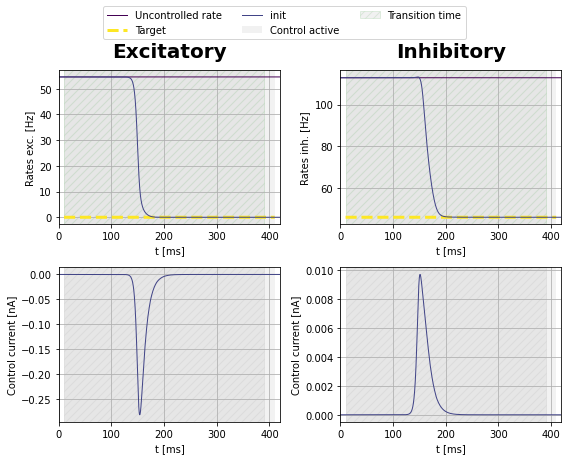

--------- 75


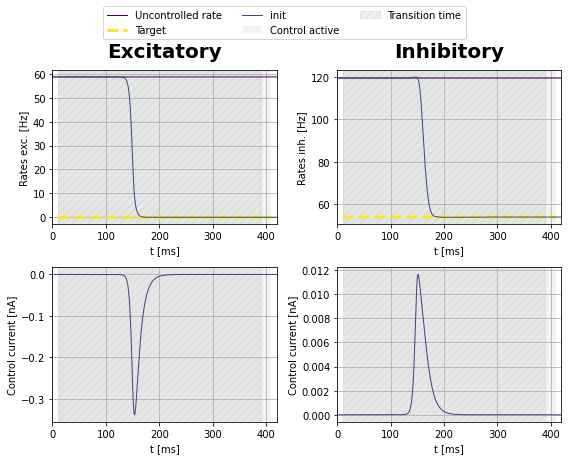

In [16]:


for i in i_range_1:
    print("---------", i)
        
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    plotFunc.plot_control_current(aln, [bestControl_1[i]],
        [costnode_1[i]], [weights_1[i]], dur,
        dur_pre, dur_post, initVars[i], target[i], '', filename_ = '', transition_time_ = trans_time,
        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)
    plt.show()

In [17]:
factor_iteration = 20
full_converge = False

for i in range(len(conv_1)):
    if i not in i_range_1:
        conv_1[i] = [True, True]
        
counter = 0

while full_converge == False:
    
    print('---------------', counter)
    if counter > 3:
        break
    
    """
    print(conv_1[::i_stepsize])
    full_converge = True
    
    for conv in conv_1[::i_stepsize]:
        if not conv[0]:
            full_converge = False
            break
        if not conv[1]:
            full_converge = False
            break
    
    if full_converge:
        print("full convergence")
        break
    """

    for i in i_range_1:        

        print("------- ", i, exc[i], inh[i])
        
        #if conv_1[i] == [True, True]:
        #    continue
            
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.
        
        if not type(bestControl_1[i]) == type(None):
            control0 = bestControl_1[i][:,:,n_pre-1:-n_post+1].copy()
        else:
            control0 = bestControl_0[i][:,:,n_pre-1:-n_post+1].copy()
            cost_1[i] = cost_0[i]
        
        cost.setParams(1.0, 1. * factor_we, 1. * factor_ws)

        setinit(initVars[i], aln)

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int( 500 * factor_iteration )

        weights_1[i] = cost.getParams()

        bestControl_1[i], bestState_1[i], cost_1[i], runtime_1[i], grad_1[i], phi_1[i], costnode_1[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)
        
        with open(final_file_1,'wb') as f:
            pickle.dump([bestControl_1, bestState_1, cost_1, runtime_1, grad_1, phi_1,
                 costnode_1, weights_1], f)
            
        j = 1
        while cost_1[i][-j] == 0.:
            j += 1
            
        if j == cost_1[i].shape[0]-1:
            print("converged for ", i)
            if conv_1[i][0]:
                conv_1[i] = [True, True]
            else:
                conv_1[i] = [True, False]
            continue
    
        print("no convergence")
        
    counter += 1

--------------- 0
-------  60 0.5500000000000003 0.6250000000000003
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12.252514157159215
Gradient descend method:  None
RUN  1 , total integrated cost =  11.132433017571458
RUN  2 , total integrated cost =  11.09719012083237
RUN  3 , total integrated cost =  11.097106296212093
RUN  4 , total integrated cost =  11.097106296212093
Control only changes marginally.
RUN  4 , total integrated cost =  11.097106296212093
Improved over  4  iterations in  7.094144743998186  seconds by  9.429965524847077  percent.
no convergence
-------  75 0.5750000000000002 0.6750000000000004
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17.643620388734558
Gradient descend method:  None
RUN  1 , total integrated cost =  14.246817712507434
RUN  2 , total integrated cost =  14.191476232021458
RUN  3 , total integrated cost =  14.191413460146917
RUN  4 , total 